In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]) 
])


In [3]:
dataset = datasets.ImageFolder(root='C:/Users/HP/Desktop/dl_project/Celebrity_Recognition/dataset/cropped/', transform=transform)


In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
print(dataset.classes)        
print(dataset.class_to_idx)  


['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']
{'Angelina Jolie': 0, 'Brad Pitt': 1, 'Denzel Washington': 2, 'Hugh Jackman': 3, 'Jennifer Lawrence': 4, 'Johnny Depp': 5, 'Kate Winslet': 6, 'Leonardo DiCaprio': 7, 'Megan Fox': 8, 'Natalie Portman': 9, 'Nicole Kidman': 10, 'Robert Downey Jr': 11, 'Sandra Bullock': 12, 'Scarlett Johansson': 13, 'Tom Cruise': 14, 'Tom Hanks': 15, 'Will Smith': 16}


In [7]:
import matplotlib.pyplot as plt
import numpy as np


In [8]:
# Mean and std used for normalization (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to unnormalize and show an image
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0)) 
    img = std * img + mean 
    img = np.clip(img, 0, 1)  
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')


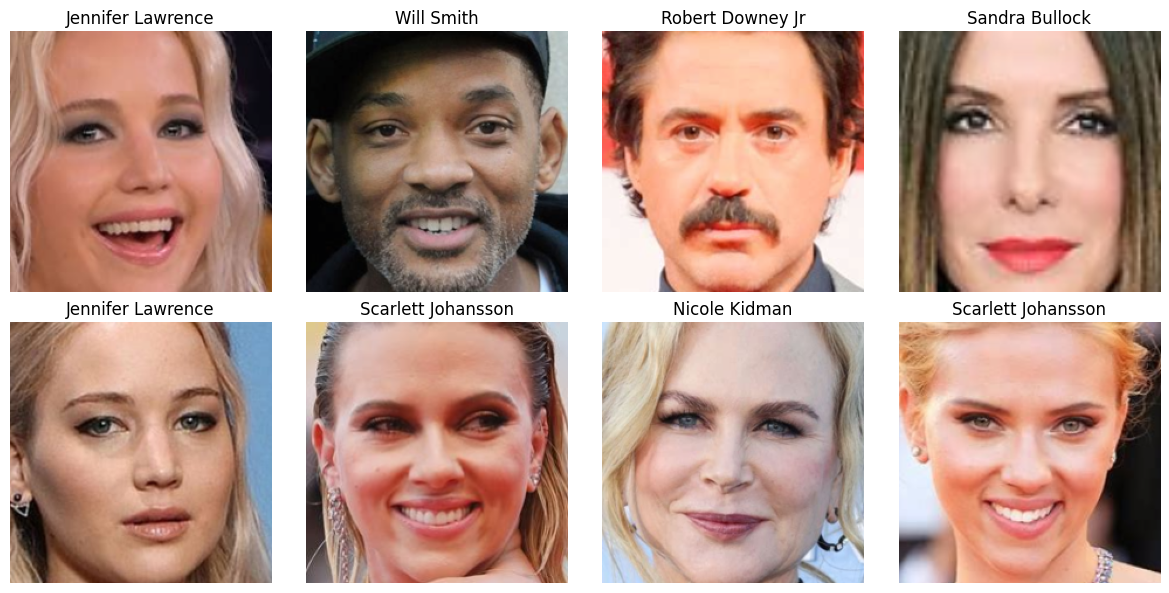

In [9]:
# Get one batch from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)


plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i], title=dataset.classes[labels[i]])
plt.tight_layout()
plt.show()


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load ResNet18 with updated weight syntax
weights = ResNet18_Weights.IMAGENET1K_V1  # or ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Assuming dataset is defined with dataset.classes
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

early_stopping = EarlyStopping(patience=2, min_delta=0.001)

num_epochs = 20 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    # Early stopping
    early_stopping(val_acc, model)
    if early_stopping.early_stop:
        print("⏹️ Early stopping triggered. Stopping training.")
        break

# Load best model weights
model.load_state_dict(early_stopping.best_model_wts)


Epoch [1/20] - Loss: 1.1637 - Train Acc: 0.6345 - Val Acc: 0.5906
Epoch [2/20] - Loss: 0.2646 - Train Acc: 0.9273 - Val Acc: 0.8623
Epoch [3/20] - Loss: 0.1456 - Train Acc: 0.9545 - Val Acc: 0.7500
Epoch [4/20] - Loss: 0.0958 - Train Acc: 0.9764 - Val Acc: 0.8370
⏹️ Early stopping triggered. Stopping training.


<All keys matched successfully>

In [11]:
model.load_state_dict(early_stopping.best_model_wts)

torch.save(model.state_dict(), "best_model.pkl")
print("Best model saved as 'best_model.pkl'")

Best model saved as 'best_model.pkl'


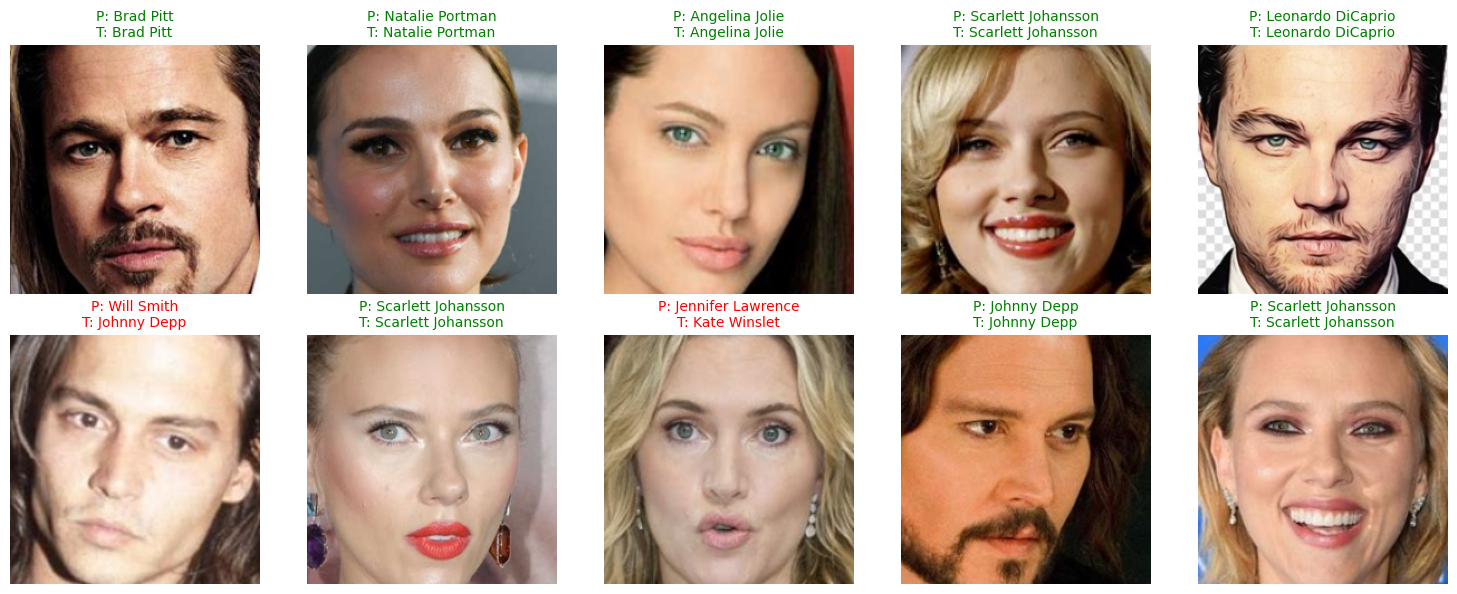

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Put model in eval mode
model.eval()

# Randomly select 10 indices
random_indices = random.sample(range(len(val_dataset)), 10)

# Unnormalize function
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img_tensor * std + mean

# Plot 10 random samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
class_names = dataset.classes

for i, idx in enumerate(random_indices):
    image_tensor, true_label = val_dataset[idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_label = torch.max(output, 1)

    # Unnormalize and convert to image
    img = unnormalize(image_tensor).numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)

    # Plot
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    pred_class = class_names[predicted_label.item()]
    true_class = class_names[true_label]
    title_color = 'green' if predicted_label.item() == true_label else 'red'
    ax.set_title(f"P: {pred_class}\nT: {true_class}", color=title_color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()
